In [8]:
import datetime
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Data Preprocessing

In [9]:
def preprocessing(file):
    #* 讀取資料
    stock_data = pd.read_excel(file)
    stock_data = stock_data.drop(columns=['證券代碼'])
    stock_year = stock_data['年月'].unique()
    stock_name = stock_data['簡稱'].unique()
    stock = stock_data[stock_data['年月'].isin(stock_year[:-1])]

    
    return stock_data

## Normalization

In [10]:
def normalization(data):
    for col in data.columns[2:-2]:
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
        
    return data

In [11]:
def split_train_test(stock, TV):
    #* 擷取股票年月與
    stock_year = stock['年月'].unique()
    
    basic_train_data = stock[stock['年月'].isin(stock_year[:TV])]
    train_label = basic_train_data['ReturnMean_year_Label']
    #* '收盤價(元)_年': 市價無法反映基本面 、 '市值(百萬元)' = 股數 * 股價
    train_data = basic_train_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])

    basic_test_data = stock[stock['年月'].isin(stock_year[TV:])]
    test_label = basic_test_data['ReturnMean_year_Label']
    #* '收盤價(元)_年': 市價無法反映基本面 、 '市值(百萬元)' = 股數 * 股價
    test_data = basic_test_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])
    
    return train_data, train_label, test_data, test_label

In [12]:
strategy_money = []
start_money = 100000  # 初始金額



def strategy(predict_data, TV):
    df = pd.read_excel('./top200_training.xls')
    stocks_data = df.drop(['年月', 'Return', 'ReturnMean_year_Label'], axis=1)
    stocks_name = df['簡稱'].unique()
    current_stock = dict()
    for n in stocks_name:
        current_stock[n] = 0
    current_money = start_money

    for pre_times in range(12 - TV):
        tmp = 0
        tmp_stock = []
        for i in range(200):
            if predict_data[pre_times * 200 + i] == -1:
                predict_name = stocks_data["簡稱"][(TV + pre_times) * 200 + i]
                current_money += stocks_data["收盤價(元)_年"][(TV + pre_times) * 200 + i] * current_stock[predict_name]
                current_stock[predict_name] = 0

            if predict_data[pre_times * 200 + i] == 1:
                tmp += 1
                tmp_stock.append(i)

        if tmp:
            per_money = current_money / tmp
            for j in tmp_stock:
                if stocks_data["收盤價(元)_年"][(TV + pre_times) * 200 + j] != 0:
                    predict_name = stocks_data["簡稱"][(TV + pre_times) * 200 + j]
                    current_stock[predict_name] += per_money / stocks_data["收盤價(元)_年"][(TV + pre_times) * 200 + j]
            current_money = 0


    for i in range(2400, 2600):
        stocks_name = stocks_data["簡稱"][i]
        current_money += current_stock[stocks_name] * stocks_data["收盤價(元)_年"][i]
        
    current_money += sum(current_stock.values()) * np.mean(stocks_data["收盤價(元)_年"])

    strategy_money.append(math.floor(current_money))




In [13]:
def ROI():
    ROI = []
    for i in range(len(strategy_money)):
        ROI.append((strategy_money[i] - start_money) / start_money)
    return ROI

def IRR():
    IRR = []
    roi = ROI()
    for i in range(len(roi) ):
        IRR.append(((roi[i] + 1) ** (1 / (11 - i)) - 1) * 100)
        
    print("IRR:", IRR)

    plt.plot(IRR)
    plt.xlabel("Train_time(year)")
    plt.ylabel("Strategy IRR(%)")
    plt.show()

1  ------------------------------------------------------------
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; to

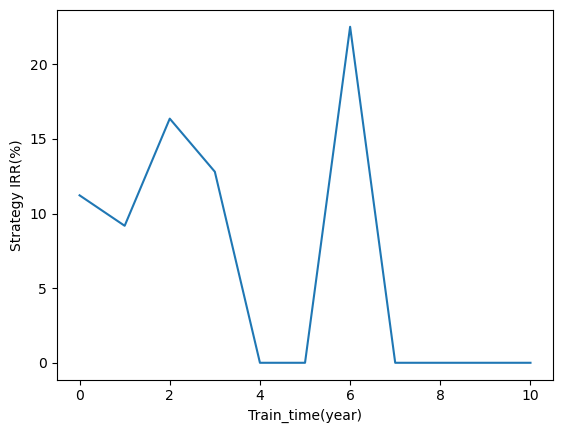

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC,SVR
from sklearn.model_selection import GridSearchCV


file_path = './top200_training.xls'
for TV in range(1,12):
    print(str(TV)+'  '+'-'*60)
    stock = preprocessing(file_path)

    normalized_stock = normalization(stock)
    X_train, y_train, X_test, y_test = split_train_test(normalized_stock, TV)

    rf = RandomForestClassifier(n_estimators=5, criterion='entropy',random_state=42)
    rf.fit(X_train, y_train)
    #print('特徵重要程度: ',rf.feature_importances_)
    feature_index = np.array(rf.feature_importances_.argsort()[-12:][::-1])
    feature_index.sort()
    new_feature = [X_train.columns[i] for i in feature_index]
    #print("feature_index",feature_index)

    X_train = X_train.loc[:][new_feature]
    X_test = X_test.loc[:][new_feature]

    param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
    grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)
    #svc_model = SVC()
    grid.fit(X_train,y_train)

    y_pred = grid.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print(y_pred)

    strategy(y_pred, TV)
    print('stratedy_money: ', strategy_money[TV - 1])

print(strategy_money)
IRR()